# **CatBoost**

### Why CatBoost?
Cat Boost is an algorithm for gradient boosting on decision trees. <br>
It's particularly interesting because it is designed to handle categorical features very efficiently and since in our dataframe there are a lot of them it can be a good option. <br>
Thanks to the fact that it's a boosting algorithm it can be pretty useful to reduce bias.

### Data Preparation
This section consists in what we already did in the first notebook, but without the encoding of the features, since we don't need it for the CatBoost model.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

#### DATA PREPARATION

train_features = df_train.columns.tolist()
test_features = df_test.columns.tolist()
features_toremove =  list(set(train_features) - set(test_features) - {'sii'})

del df_train['id']
for col in features_toremove:
    del df_train[col]
df_train.dropna(subset=['sii'], inplace=True)

physical_measures_df = pd.read_csv('data/physical_measures.csv')

df_train = df_train.merge( physical_measures_df, on=['Basic_Demos-Age', 'Basic_Demos-Sex'], suffixes=('', '_avg'))
cols = ['Physical-BMI','Physical-Height','Physical-Weight','Physical-Waist_Circumference','Physical-Diastolic_BP','Physical-HeartRate','Physical-Systolic_BP']
tot_nan_phys = df_train[cols].isna().all(axis=1)

for col in cols:
    df_train.loc[tot_nan_phys, col] = df_train.loc[tot_nan_phys, f"{col}_avg"]
    del df_train[f"{col}_avg"]


X = df_train.iloc[:, :-1]
y = df_train.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

is_numerical = np.array([np.issubdtype(dtype, np.number) for dtype in X.dtypes])  
numerical_idx = np.flatnonzero(is_numerical) 
new_X_train = X_train.iloc[:, numerical_idx]
new_X_test = X_test.iloc[:, numerical_idx]


scaler = StandardScaler()
imputer = KNNImputer(n_neighbors=3)

scaled_train = scaler.fit_transform(new_X_train)
X_array = imputer.fit_transform(scaled_train)
X_array = scaler.inverse_transform(X_array)
new_X_train = pd.DataFrame(X_array, columns=new_X_train.columns, index=new_X_train.index) # convert into a dataframe since X_array is of type ndarray

scaled_test = scaler.fit_transform(new_X_test)
X_array = imputer.fit_transform(scaled_test)
X_array = scaler.inverse_transform(X_array)
new_X_test = pd.DataFrame(X_array, columns=new_X_test.columns, index=new_X_test.index)


categorical_idx = np.flatnonzero(is_numerical==False)
categorical_X_train = X_train.iloc[:, categorical_idx]
categorical_X_test = X_test.iloc[:, categorical_idx]

imputer = SimpleImputer(strategy='most_frequent')
X_array = imputer.fit_transform(categorical_X_train)
categorical_X_train = pd.DataFrame(X_array, columns=categorical_X_train.columns, index=categorical_X_train.index)

X_array = imputer.fit_transform(categorical_X_test)
categorical_X_test = pd.DataFrame(X_array, columns=categorical_X_test.columns, index=categorical_X_test.index)

new_X_train = pd.concat([new_X_train, categorical_X_train], axis=1)
new_X_test = pd.concat([new_X_test, categorical_X_test], axis=1)

### First Model
We will start by training a basic CatBoost model without any hyperparameter specified and see how it does behave. <br>
For this model we just have to specify which are the categorical features, since they have to be passed to the model separately

In [6]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

cat_features = X.columns[categorical_idx].tolist() # specified the names of the categorical features
base_model = CatBoostClassifier(iterations=100,cat_features=cat_features)

base_model.fit(new_X_train, y_train)
test_acc = accuracy_score(y_true = y_test, y_pred = base_model.predict(new_X_test) )
print("Test Accuracy: {:.3f}".format(test_acc) )

Learning rate set to 0.5
0:	learn: 1.0907455	total: 46ms	remaining: 4.55s
1:	learn: 0.9797216	total: 134ms	remaining: 6.59s
2:	learn: 0.9193180	total: 180ms	remaining: 5.82s
3:	learn: 0.8824870	total: 221ms	remaining: 5.31s
4:	learn: 0.8574239	total: 305ms	remaining: 5.8s
5:	learn: 0.8382865	total: 344ms	remaining: 5.39s
6:	learn: 0.8243441	total: 383ms	remaining: 5.09s
7:	learn: 0.8114112	total: 466ms	remaining: 5.36s
8:	learn: 0.7979338	total: 507ms	remaining: 5.13s
9:	learn: 0.7837972	total: 550ms	remaining: 4.95s
10:	learn: 0.7726161	total: 638ms	remaining: 5.16s
11:	learn: 0.7656409	total: 686ms	remaining: 5.03s
12:	learn: 0.7521165	total: 739ms	remaining: 4.94s
13:	learn: 0.7459396	total: 857ms	remaining: 5.27s
14:	learn: 0.7319599	total: 960ms	remaining: 5.44s
15:	learn: 0.7252126	total: 1.01s	remaining: 5.33s
16:	learn: 0.7196380	total: 1.16s	remaining: 5.66s
17:	learn: 0.7077917	total: 1.25s	remaining: 5.7s
18:	learn: 0.6954013	total: 1.3s	remaining: 5.57s
19:	learn: 0.6863760

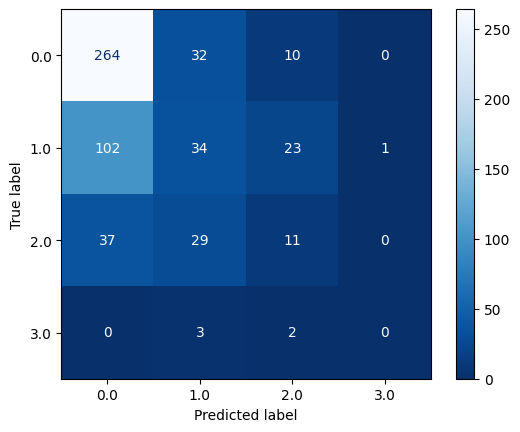

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    estimator=base_model,
    X=new_X_test, y=y_test,
    cmap = 'Blues_r')

We can see that even if it's just the basic model, we have quite balanced predictions, but we want to tune the hyperparameters and get a better model.

### Tuning the Hyperparameter
We will tune the hyperparametersusing a k-fold cross validation that tunes the hyperparameters automatically.<br>
The parameters we are going to tune are:
- learning rate -> how much the model adjust at each step
- depth -> depth of each tree
- iterations -> number of boosting rounds
- L2 regularization -> regularization parameter that helps control model complexity<br>

Other parameter like the loss function will not be tuned since we have 4 possible class label so we are going to use `MultiClass`.

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

base_model = CatBoostClassifier(cat_features=cat_features, loss_function='MultiClass', early_stopping_rounds=50)
parameters = {
    'depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1],
    'l2_leaf_reg': [3, 5, 10],
    'iterations': [500]
}
tuned_model = GridSearchCV(base_model, parameters, cv=5, scoring='accuracy', n_jobs=-1)
tuned_model.fit(new_X_train, y_train)
print ("Best Score: {:.3f}".format(tuned_model.best_score_) )
print("Best Params: ", tuned_model.best_params_)
test_acc = accuracy_score(y_true = y_test, y_pred = tuned_model.predict(new_X_test) )
print("Test Accuracy: {:.3f}".format(test_acc) )

0:	learn: 1.3443163	total: 992ms	remaining: 8m 15s
0:	learn: 1.3029181	total: 1.32s	remaining: 11m
0:	learn: 1.3024412	total: 1.27s	remaining: 10m 36s
0:	learn: 1.3044347	total: 1.32s	remaining: 10m 58s
1:	learn: 1.3088623	total: 1.57s	remaining: 6m 32s
1:	learn: 1.2398587	total: 1.65s	remaining: 6m 51s
2:	learn: 1.1911064	total: 2.22s	remaining: 6m 8s
2:	learn: 1.2791633	total: 2.39s	remaining: 6m 36s
3:	learn: 1.1474292	total: 2.63s	remaining: 5m 26s
1:	learn: 1.2418520	total: 2.58s	remaining: 10m 43s
1:	learn: 1.2428737	total: 2.72s	remaining: 11m 16s
3:	learn: 1.2500361	total: 2.81s	remaining: 5m 48s
4:	learn: 1.1102829	total: 3.2s	remaining: 5m 16s
2:	learn: 1.1959185	total: 3.29s	remaining: 9m 6s
5:	learn: 1.0794190	total: 3.69s	remaining: 5m 3s
4:	learn: 1.2242551	total: 3.87s	remaining: 6m 22s
2:	learn: 1.1940053	total: 3.86s	remaining: 10m 40s
6:	learn: 1.0548757	total: 4.19s	remaining: 4m 55s
0:	learn: 1.3455572	total: 1.4s	remaining: 11m 38s
3:	learn: 1.1537590	total: 4.47s	

We got a more accurate model. <br>
Let's investigate better the performance using a Confusion Matrix, in this way we can now which are the label that are better and worst predicted:

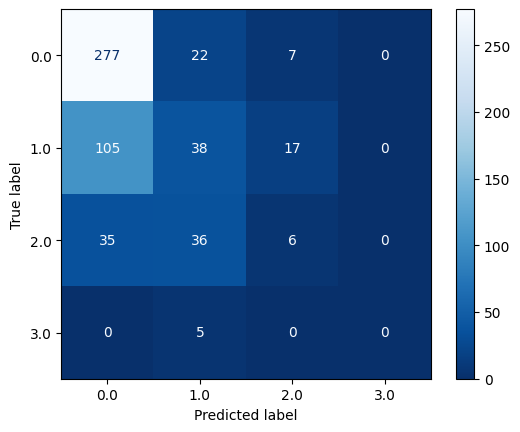

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    estimator=tuned_model,
    X=new_X_test, y=y_test,
    cmap = 'Blues_r')

We can see that the model is quite unbalanced, let's see what happen if we try to balance a bit the classes

0:	learn: 1.3700603	total: 69.3ms	remaining: 34.6s
1:	learn: 1.3504986	total: 87.4ms	remaining: 21.8s
2:	learn: 1.3355762	total: 142ms	remaining: 23.5s
3:	learn: 1.3231370	total: 145ms	remaining: 18s
4:	learn: 1.3125560	total: 148ms	remaining: 14.7s
5:	learn: 1.2978473	total: 203ms	remaining: 16.7s
6:	learn: 1.2865335	total: 259ms	remaining: 18.2s
7:	learn: 1.2764550	total: 323ms	remaining: 19.9s
8:	learn: 1.2658055	total: 335ms	remaining: 18.3s
9:	learn: 1.2536685	total: 387ms	remaining: 19s
10:	learn: 1.2427644	total: 439ms	remaining: 19.5s
11:	learn: 1.2344173	total: 485ms	remaining: 19.7s
12:	learn: 1.2257549	total: 541ms	remaining: 20.3s
13:	learn: 1.2161038	total: 598ms	remaining: 20.8s
14:	learn: 1.2065548	total: 663ms	remaining: 21.4s
15:	learn: 1.1962509	total: 726ms	remaining: 22s
16:	learn: 1.1861764	total: 799ms	remaining: 22.7s
17:	learn: 1.1808090	total: 804ms	remaining: 21.5s
18:	learn: 1.1718823	total: 865ms	remaining: 21.9s
19:	learn: 1.1661999	total: 904ms	remaining: 

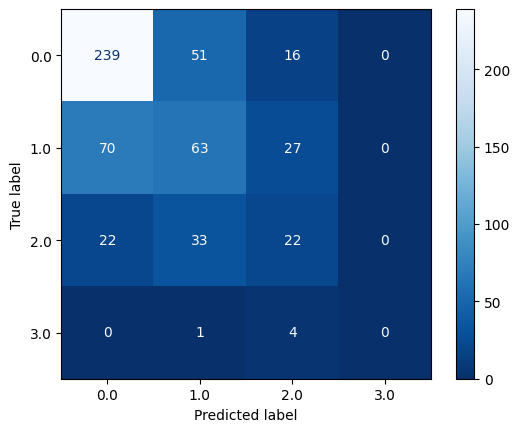

In [85]:
weights = [1,2,4,8]

model = CatBoostClassifier(iterations=500, cat_features=cat_features, depth=8, l2_leaf_reg=5, learning_rate=0.05, 
                                class_weights=weights, loss_function='MultiClass', early_stopping_rounds=50)

model.fit(new_X_train, y_train)
test_acc = accuracy_score(y_true = y_test, y_pred = model.predict(new_X_test) )
print("Test Accuracy: {:.3f}".format(test_acc) )

ConfusionMatrixDisplay.from_estimator(
    estimator=model,
    X=new_X_test, y=y_test,
    cmap = 'Blues_r')

This way we get a more balanced and even more accurate model. There is still a problem with predicting instances of class 3 but that's quite normal since there are very few instances so the model isn't trained a lot on them. <br>
This time we will not give a weight that is inversely proportional to the frequency of a label since the basic model is already slighty balanced and giving inversely proportional weight will compromise the accuracy too much.

### Feature Subset Selection
Now we have a quite balance and tuned model based on all the features of the dataset. <br>
With the goal of adding robustness and reducing overfitting, we will now select a subset of the most useful features. <br>
This time, since `RFECV` doesn't know how to handle categorical variables, we are going to perform the selection of the subset using the embedded approaches, so starting with all the features we compute their importance and remove the least important at every cycle until we got a model where removing features will compromise the performances. <br>

Before starting the selection procedure we will take a look at the most important features:

['Fitness_Endurance-Time_Sec', 'PAQ_A-PAQ_A_Total', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday', 'FGC-Season']


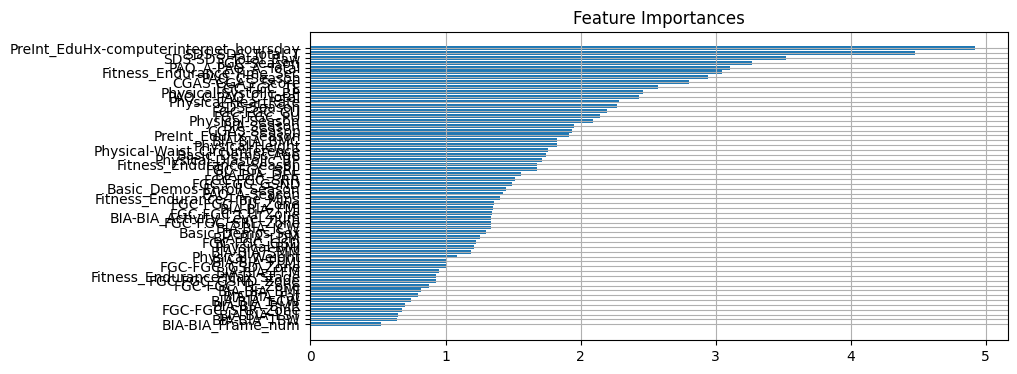

In [86]:
feature_names = new_X_train.columns.tolist()

important_features = [name for name, importance in zip(feature_names, model.get_feature_importance()) if importance > 3]
print(important_features)

fig, ax = plt.subplots(figsize=(9, 4))
ax.barh(range(new_X_train.shape[1]), sorted(model.get_feature_importance())[::-1])
ax.set_title("Feature Importances")
ax.set_yticks(range(new_X_train.shape[1]))
ax.set_yticklabels(np.array(feature_names)[np.argsort(model.get_feature_importance())[::-1]])
ax.invert_yaxis() 
ax.grid()

We can see that this time the most important features are slighty different from the one we got using RandomForest. <br>
Indeed we got some SDS features that scale to categorize sleep disorders in children like the other time, but this time we also got features relative to:
- Physical Activity Questionnaire: children partecipation in vigorous activities
- Internet use
- FitnessGram: measurements of cardiovascular fitness assessed using the NHANES treadmill protocol <br>

Another important thing we can notice is that this time also categorical values have an importance, probably thanks to CatBoost and it's automatic categorical features management. <br>
We can also notice that this time features about Bio-electric Impedance Analysis are less significative.


We will now perform the selection of the features using as model the last one we computed with tuned hyperparameters and balanced weights. <br>
The selection is going to be a cross validation in this way we can use all the data in the train set for the training step thanks to the fact that every time a different sample of the set is used for the validation part. <br>
For the subset selection we will test the performance of the top $k$ most important features starting from 20 by adding 5 features at time, and we are going to keep the one where an addition of features doesn't give us a better accuracy. <br>

In [ ]:
from sklearn.model_selection import cross_val_score

for col in cat_features:
    new_X_train[col] = new_X_train[col].astype('category')
    
best_features = np.argsort(model.get_feature_importance())[::-1]
accuracy = []
for k in range(20,len(best_features),5):
    
    X_subset = new_X_train.iloc[:, best_features[:k]]
    cat = [ X_subset.columns.get_loc(col) for col in cat_features if col in X_subset.columns] # indices of the categorical features that are selecteed by the subset
    sub_model = CatBoostClassifier(iterations=500, cat_features=cat, depth=8, l2_leaf_reg=5, learning_rate=0.05, 
                                class_weights=weights, loss_function='MultiClass', early_stopping_rounds=50)
    scores = cross_val_score(sub_model,
                             new_X_train.iloc[:,best_features[:k]], y_train,
                             cv=5, scoring='accuracy')
    accuracy += [(k, scores.mean())]

0:	learn: 1.3686657	total: 48.8ms	remaining: 24.4s
1:	learn: 1.3510494	total: 76.7ms	remaining: 19.1s
2:	learn: 1.3331386	total: 137ms	remaining: 22.8s
3:	learn: 1.3197000	total: 141ms	remaining: 17.4s
4:	learn: 1.3068898	total: 143ms	remaining: 14.2s
5:	learn: 1.2974751	total: 146ms	remaining: 12s
6:	learn: 1.2881123	total: 150ms	remaining: 10.6s
7:	learn: 1.2789097	total: 154ms	remaining: 9.5s
8:	learn: 1.2680956	total: 162ms	remaining: 8.84s
9:	learn: 1.2628751	total: 163ms	remaining: 7.99s
10:	learn: 1.2539523	total: 165ms	remaining: 7.35s
11:	learn: 1.2455419	total: 173ms	remaining: 7.05s
12:	learn: 1.2373706	total: 193ms	remaining: 7.22s
13:	learn: 1.2294485	total: 216ms	remaining: 7.48s
14:	learn: 1.2189600	total: 237ms	remaining: 7.66s
15:	learn: 1.2107868	total: 261ms	remaining: 7.9s
16:	learn: 1.2063993	total: 266ms	remaining: 7.55s
17:	learn: 1.1974376	total: 289ms	remaining: 7.75s
18:	learn: 1.1944102	total: 291ms	remaining: 7.37s
19:	learn: 1.1895067	total: 293ms	remaining

In [88]:
print(accuracy)
best_k, best_score = max(accuracy, key=lambda x: x[1]) # key extract the second element (the accuracy) from each tuple
best_k

[(20, 0.5799901779463549), (25, 0.5937023917745524), (30, 0.5950680751909554), (35, 0.5877537799233045), (40, 0.5923273042642341), (45, 0.5914046581611861), (50, 0.5854748544977693), (55, 0.5927797456715045)]


30

We got the higher accuracy with 30, so we are going to keep the best 30 features for the prediction, let's how the classifier behave with the test set and who they are:

In [110]:
sub_features = np.array(feature_names)[best_features[:30]]
X_train_subset = new_X_train.iloc[:, best_features[:30]]
X_test_subset = new_X_test.iloc[:, best_features[:30]]
cat2 = [i for i in cat_features if i in sub_features]
sub_model = CatBoostClassifier(iterations=500, cat_features=cat2, depth=8, l2_leaf_reg=5, learning_rate=0.05, 
                                class_weights=weights, loss_function='MultiClass', early_stopping_rounds=50)

sub_model.fit(X_train_subset, y_train)
test_acc = accuracy_score(y_true = y_test, y_pred = sub_model.predict(X_test_subset) )
print("Test Accuracy: {:.3f}".format(test_acc) )

0:	learn: 1.3700362	total: 53.2ms	remaining: 26.5s
1:	learn: 1.3522148	total: 108ms	remaining: 26.9s
2:	learn: 1.3350078	total: 137ms	remaining: 22.7s
3:	learn: 1.3194296	total: 171ms	remaining: 21.1s
4:	learn: 1.3044686	total: 178ms	remaining: 17.6s
5:	learn: 1.2904469	total: 216ms	remaining: 17.8s
6:	learn: 1.2796013	total: 220ms	remaining: 15.5s
7:	learn: 1.2666910	total: 229ms	remaining: 14.1s
8:	learn: 1.2544276	total: 242ms	remaining: 13.2s
9:	learn: 1.2427179	total: 273ms	remaining: 13.4s
10:	learn: 1.2320591	total: 315ms	remaining: 14s
11:	learn: 1.2225558	total: 346ms	remaining: 14.1s
12:	learn: 1.2143815	total: 384ms	remaining: 14.4s
13:	learn: 1.2056467	total: 419ms	remaining: 14.5s
14:	learn: 1.1985028	total: 455ms	remaining: 14.7s
15:	learn: 1.1893584	total: 493ms	remaining: 14.9s
16:	learn: 1.1854889	total: 495ms	remaining: 14.1s
17:	learn: 1.1764561	total: 538ms	remaining: 14.4s
18:	learn: 1.1687977	total: 572ms	remaining: 14.5s
19:	learn: 1.1632636	total: 582ms	remainin

We got a slighty lower accuracy, but we have the benefit of a reduced complexity and a reduced risk of overfit. <br>
Let's get some more insight from the confusion matrix:

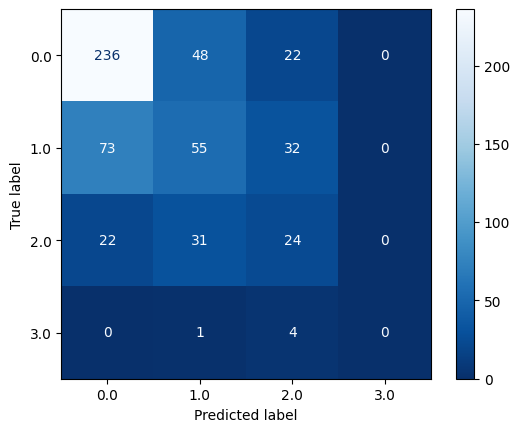

In [111]:
ConfusionMatrixDisplay.from_estimator(
    estimator=sub_model,
    X=X_test_subset, y=y_test,
    cmap = 'Blues_r')

The confusion matrix is quite similiar to the one of the previous model, meaning that the accuracy measures are stable. <br>
Let's now take a look of the selected features:

['PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'SDS-SDS_Total_Raw', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season', 'PAQ_C-PAQ_C_Total', 'Physical-Height', 'Physical-Waist_Circumference']


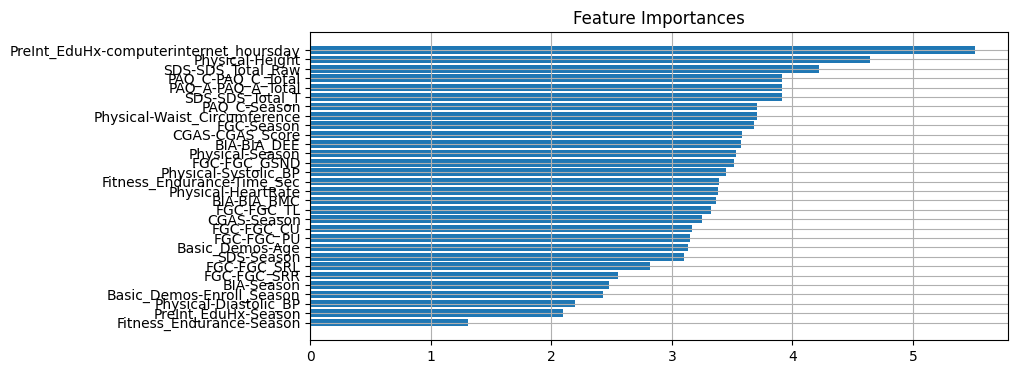

In [115]:
subset_feature_names = X_train_subset.columns.tolist()

important_features = [name for name, importance in zip(subset_feature_names, sub_model.get_feature_importance()) if importance > 3.7]
print(important_features)

fig, ax = plt.subplots(figsize=(9, 4))
ax.barh(range(X_train_subset.shape[1]), sorted(sub_model.get_feature_importance())[::-1])
ax.set_title("Feature Importances")
ax.set_yticks(range(X_train_subset.shape[1]))
ax.set_yticklabels(np.array(subset_feature_names)[np.argsort(sub_model.get_feature_importance())[::-1]])
ax.invert_yaxis() 
ax.grid()

We can see that the most important features are similiar to the model that include all the features, this means that there wasn't high correlation between the best features and the removed one. <br>
We can also notice that the Physical Measures grow in relevance, this could be thanks to the elimination of attributes which correlation had them penalized.

### Investigating Problematic Instances
Now that our model is tuned and is based on a subset of features, which makes it less complex and improve computational efficiency, we want to investigate the instances that happen to be the most wrong predictions. <br>
As in the last notebook we will chase them using the probability of prediction and taking the one with more confidence in the wrong class.

In [125]:
y_proba = sub_model.predict_proba(X_test_subset) # for each instances get the probability that it belongs to each class
confidence = np.max(y_proba, axis=1) # we get with what probability an instance was mapped to a class label
y_pred = sub_model.predict(X_test_subset).flatten()
results_df = pd.DataFrame({
    'true_label': y_test,
    'pred_label': y_pred,
    'confidence': confidence
})
results_df['correct'] = results_df['true_label'] == results_df['pred_label']
results_df['index'] = y_test.index

most_wrong = results_df[~results_df['correct']].sort_values(by='confidence', ascending=False).head(500)
print(most_wrong.head(10))

      true_label  pred_label  confidence  correct  index
891          1.0         0.0    0.906302    False    891
1657         1.0         0.0    0.881787    False   1657
2181         1.0         0.0    0.880875    False   2181
1222         2.0         0.0    0.860508    False   1222
70           1.0         0.0    0.839398    False     70
32           2.0         0.0    0.802221    False     32
436          1.0         0.0    0.789967    False    436
2010         1.0         0.0    0.787674    False   2010
2502         2.0         0.0    0.771716    False   2502
2470         1.0         0.0    0.757939    False   2470


We can see that the problem appear mostly when the predicted label is 0 but the true label is 1 or 2. <br>
This is probably due to the fact that class 0 is the one with more instances and even if we have weighted the classes to reduce this unbalance, we still have to deal with it.

We want now to see how these instances behave compared to all the instances. <br>
To do this we will use the same method we used with the Random Forest model, so plot the distribution of the most wrong instances and look at the differences with the distribution of all the instances. <br>
We will focus on the distribution of the most important features since they are the one that have a greatest influence on the model.

In [128]:
important_features = [name for name, importance in zip(subset_feature_names, sub_model.get_feature_importance()) if importance > 4]
print(important_features)

['PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_Raw', 'Physical-Height']


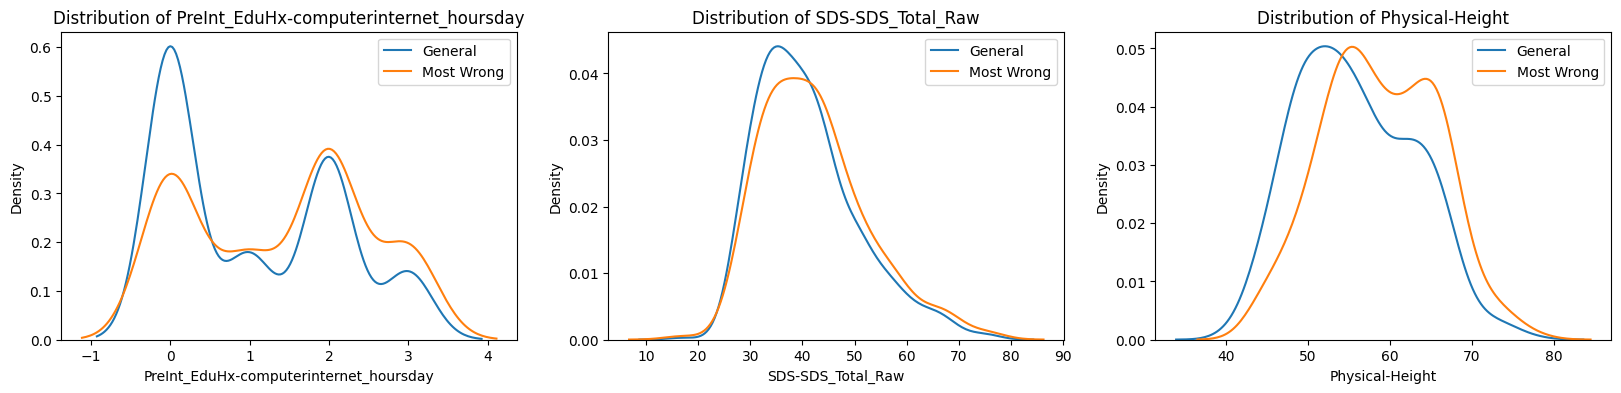

In [130]:
import seaborn as sns
fig, ax = plt.subplots(1, 3, figsize=(20,4))

for i in range(len(important_features)):
    sns.kdeplot(X_test_subset[important_features[i]], label='General', ax=ax[i])
    sns.kdeplot(X_test_subset.loc[most_wrong['index']][important_features[i]], label='Most Wrong', ax=ax[i])

    ax[i].legend()
    ax[i].set_xlabel(important_features[i])
    ax[i].set_ylabel('Density')
    ax[i].set_title(f'Distribution of {important_features[i]}')

We are also curious of the instances that were the easiest to predict. <br>
They are the one that have the highest confidence and a correct prediction.

In [131]:
most_correct = results_df[results_df['correct']].sort_values(by='confidence', ascending=False).head(500)
print(most_correct.head(10))

      true_label  pred_label  confidence  correct  index
2123         0.0         0.0    0.945871     True   2123
999          0.0         0.0    0.921645     True    999
1093         0.0         0.0    0.920122     True   1093
1662         0.0         0.0    0.918326     True   1662
1087         0.0         0.0    0.909486     True   1087
1213         0.0         0.0    0.905157     True   1213
1057         0.0         0.0    0.902818     True   1057
2506         0.0         0.0    0.901219     True   2506
879          0.0         0.0    0.898953     True    879
1647         0.0         0.0    0.898681     True   1647


We can see that they are all instances of class 0. <br>
We could have expect that since they are the one with more instances so there were more data to train with. <br>
A difference we can see between CatBoost and Random Forest is that CatBoost is on average more confident on the prediction than the Random Forest, which can be seen as a more well-calibrated model or overfitting when the prediction is not accurate.

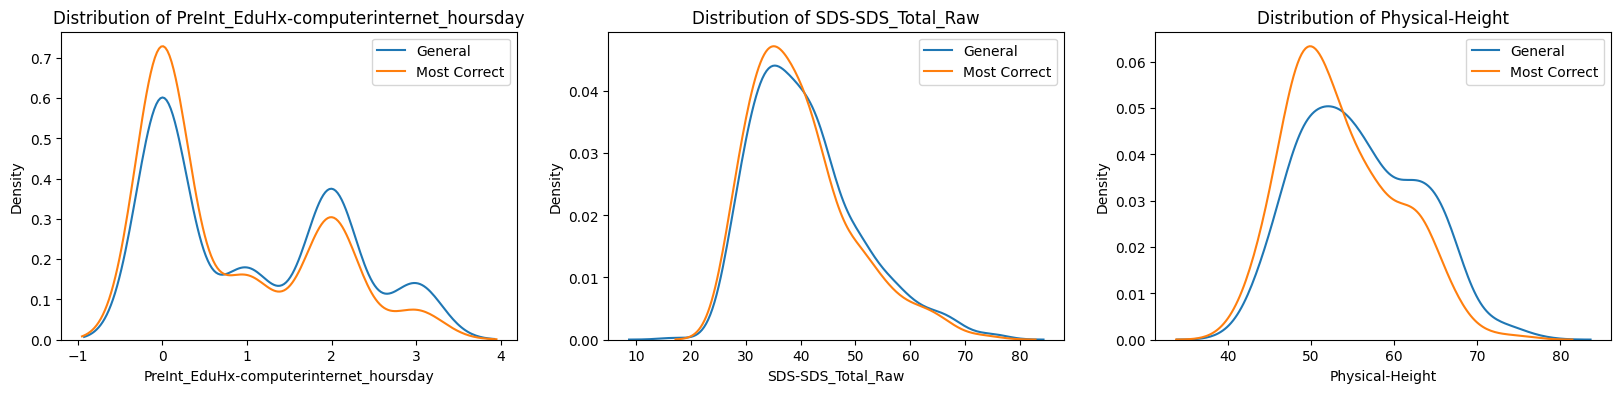

In [132]:
import seaborn as sns
fig, ax = plt.subplots(1, 3, figsize=(20,4))

for i in range(len(important_features)):
    sns.kdeplot(X_test_subset[important_features[i]], label='General', ax=ax[i])
    sns.kdeplot(X_test_subset.loc[most_correct['index']][important_features[i]], label='Most Correct', ax=ax[i])

    ax[i].legend()
    ax[i].set_xlabel(important_features[i])
    ax[i].set_ylabel('Density')
    ax[i].set_title(f'Distribution of {important_features[i]}')

We can see that the distribution of the easiest to predict is the opposite of the most wrong instances. <br>
Indeed for what concerns the use of internet per day we get an higher density when the number is 0 and a lower density when the hours are 2 or 3, this can be due to the fact that usually kids with more hours of internet use are the one that are more affected to dependency which are the classes that our predictor have more difficulties to predict. <br>
The distribution of the Sleep disturbance scale is quite the same with a slighty higher density when the value is lower. <br>
For what concerns physical height we can see that shorter child are the easier to predict, this could be due to the fact that a shorter child is also younger and for a small kid it's difficult to have an high sii so it's easier to be predicted by our model.